# Data cleaning & Analysis

## Dataframe creation and visualization

In [ ]:
import pandas as pd

Norrbacka_EL = pd.read_csv('/work/Fastighets_Energy_Data.Norrbacka_EL.csv')
Norrbacka_EL

,_id,Förbrukning,Period
0,6108e905e438257ee378ae8c,Förbrukning,Period
1,6108e905e438257ee378ae8d,Förbrukning,Period
2,6108e905e438257ee378ae8e,Förbrukning,Period
3,6108e905e438257ee378ae8f,120.52,2015-09-01T00:00:00.000Z
4,6108e905e438257ee378ae90,162.25,2015-09-02T00:00:00.000Z
...,...,...,...
3215,655635b9c7de6d6d0ee8da47,308.238,2023-11-11T00:00:00.000Z
3216,655635b9c7de6d6d0ee8da49,313.662,2023-11-12T00:00:00.000Z
3217,655635b9c7de6d6d0ee8da4b,801.612,2023-11-13T00:00:00.000Z
3218,655635b9c7de6d6d0ee8da4d,797.88,2023-11-14T00:00:00.000Z


In [ ]:
# Define the Swedish to English month mapping
swedish_to_english_months = {
    'jan': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'apr': 'Apr', 'maj': 'May', 'jun': 'Jun',
    'jul': 'Jul', 'aug': 'Aug', 'sep': 'Sep', 'okt': 'Oct', 'nov': 'Nov', 'dec': 'Dec'
}

# Define a function to unify time format
def unify_time_format(date_str):
    if date_str == 'Period':
        return pd.NaT

    try:
        if "T" in date_str and "Z" in date_str:
            return pd.to_datetime(date_str, errors='coerce', utc=True).tz_convert(None)
    except Exception:
        pass

    date_str_lower = date_str.lower()
    for swe, eng in swedish_to_english_months.items():
        date_str_lower = date_str_lower.replace(swe, eng.capitalize())

    date_formats = ["%d %b %Y %H:%M", "%d/%m/%y %H:%M", "%d/%m/%Y %H:%M"]
    for fmt in date_formats:
        try:
            parsed_date = pd.to_datetime(date_str_lower, format=fmt, exact=True, errors='coerce')
            if pd.notnull(parsed_date):
                return parsed_date
        except ValueError:
            continue

    return pd.NaT

# Apply the function to the 'Period' column
Norrbacka_EL['Period'] = Norrbacka_EL['Period'].astype(str).apply(unify_time_format)

# Drop rows with invalid dates or missing 'Förbrukning'
Norrbacka_EL.dropna(subset=['Period', 'Förbrukning'], inplace=True)

# Convert 'Förbrukning' to a numeric type, handling potential decimal separators
Norrbacka_EL['Förbrukning'] = pd.to_numeric(Norrbacka_EL['Förbrukning'].str.replace(',', '.'), errors='coerce')

# Convert 'Period' column to datetime
Norrbacka_EL['Period'] = pd.to_datetime(Norrbacka_EL['Period'], errors='coerce')

# Sort and reset the index
Norrbacka_EL.sort_values(by='Period', inplace=True)
Norrbacka_EL.reset_index(drop=True, inplace=True)

Norrbacka_EL.index.name = 'Period'
Norrbacka_EL.set_index('Period', inplace=True)

# Convert the datetime index to UTC timezone
Norrbacka_EL.index = Norrbacka_EL.index.tz_localize(None).tz_localize('UTC')

import plotly.graph_objs as go


# Create a trace for the time series
trace = go.Scatter(x=Norrbacka_EL.index, y=Norrbacka_EL['Förbrukning'], mode='lines', name='Consumption')

# Create layout for the plot
layout = go.Layout(title='Electricity Consumption Norrbacka',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Consumption'))

# Create Figure object
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

## Handling Missing values

In [ ]:
# Check for missing values
Norrbacka_EL.isna().sum()

# No missing values

_id            0
Förbrukning    0
dtype: int64

## Descriptive stats

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats

# Assuming 'df' is your DataFrame containing the data
# Plot histogram with Plotly
fig = px.histogram(Norrbacka_EL, x='Förbrukning', nbins=30, title='Distribution of Förbrukning')
fig.update_layout(xaxis_title='Value', yaxis_title='Frequency')
fig.show()

# Calculate kurtosis and skewness
kurtosis_value = stats.kurtosis(Norrbacka_EL['Förbrukning'])
skewness_value = stats.skew(Norrbacka_EL['Förbrukning'])

print("Kurtosis:", kurtosis_value)
print("Skewness:", skewness_value)

# Assuming 'df' is your DataFrame containing the data
# Calculate descriptive statistics
mean_value = Norrbacka_EL['Förbrukning'].mean()
median_value = Norrbacka_EL['Förbrukning'].median()
mode_value = Norrbacka_EL['Förbrukning'].mode()[0]  # Mode can have multiple values, so take the first one
std_dev = Norrbacka_EL['Förbrukning'].std()

# Print descriptive statistics
print("Mean:", mean_value)
print("Median:", median_value)
print("Mode:", mode_value)
print("Standard Deviation:", std_dev)


Kurtosis: -1.2727900279092372
Skewness: -0.4216269482105712
Mean: 529.0987038667085
Median: 600.0
Mode: 137.08
Standard Deviation: 217.32794661886018


## Outlier removal

In [ ]:
# Remove rows with 0 values in 'corrected_value' feature
Norrbacka_EL = Norrbacka_EL[Norrbacka_EL['Förbrukning'] != 0]

# Calculate Z-scores for the data
Norrbacka_EL['z_score'] = (Norrbacka_EL['Förbrukning'] - Norrbacka_EL['Förbrukning'].mean()) / Norrbacka_EL['Förbrukning'].std()

# Define a threshold for identifying outliers
threshold = 2.0  #From Zahraa's model

# Identify outliers based on Z-score
outliers = Norrbacka_EL[abs(Norrbacka_EL['z_score']) > threshold]

# Print the number of outliers excluding zeros
print("Number of outliers (excluding zeros):", outliers.shape[0])

# Plot original data
fig = go.Figure()
# Create a trace for the time series
fig.add_trace(go.Scatter(x=Norrbacka_EL.index, y=Norrbacka_EL['Förbrukning'], mode='lines', name='Consumption'))

# Add non-zero outliers to the plot
fig.add_trace(go.Scatter(x=outliers.index, y=outliers['Förbrukning'], mode='markers', 
                         marker=dict(color='red', size=8), name='Outliers (Z-Score)'))

# Update layout
fig.update_layout(title='Time Series with Outliers (Z-Score and Zero Values)',
                  xaxis_title='Date',
                  yaxis_title='Consumption')

# Show plot
fig.show()

# Remove outliers based on the Z-score
Norrbacka_EL = Norrbacka_EL[abs(Norrbacka_EL['z_score']) <= threshold]

Number of outliers (excluding zeros): 3


## Seasonal Decomposition

In [ ]:
!pip install statsmodels==0.14.1


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import statsmodels.api as sm

# Decompose data by selecting the appropriate frequency
decomp = sm.tsa.seasonal_decompose(Norrbacka_EL['Förbrukning'], period=365)

# Create subplots
fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    subplot_titles=("Original Data", "Trend", "Seasonal", "Residual"))

# Add original data trace
fig.add_trace(go.Scatter(x=Norrbacka_EL.index, y=Norrbacka_EL['Förbrukning'], mode='lines', name='Original'),
              row=1, col=1)

# Add trend trace
fig.add_trace(go.Scatter(x=Norrbacka_EL.index, y=decomp.trend, mode='lines', name='Trend'),
              row=2, col=1)

# Add seasonal trace
fig.add_trace(go.Scatter(x=Norrbacka_EL.index, y=decomp.seasonal, mode='lines', name='Seasonal'),
              row=3, col=1)

# Add residual trace
fig.add_trace(go.Scatter(x=Norrbacka_EL.index, y=decomp.resid, mode='lines', name='Residual'),
              row=4, col=1)

# Update layout
fig.update_layout(title="Time Series Decomposition Electricity Consumption Norrbacka",
                  xaxis_title="Date",
                  showlegend=False)

# Show plot
fig.show()


## ADF Test

In [ ]:
# Check if data is stationary

from statsmodels.tsa.stattools import adfuller, kpss

# Stationarity test using Augmented Dickey-Fuller test
adf_result = adfuller(Norrbacka_EL['Förbrukning'].dropna())

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.825333
p-value: 0.000049
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


## Cyclical features

In [ ]:
import pandas as pd
import numpy as np

# Extract day of week, day of month, month, and day of year from the date
Norrbacka_EL['dayofweek'] = Norrbacka_EL.index.dayofweek
Norrbacka_EL['day'] = Norrbacka_EL.index.day
Norrbacka_EL['month'] = Norrbacka_EL.index.month
Norrbacka_EL['dayofyear'] = Norrbacka_EL.index.dayofyear

# Create cyclical features for day of week
Norrbacka_EL['dayofweek_sin'] = np.sin(2 * np.pi * Norrbacka_EL['dayofweek'] / 7)
Norrbacka_EL['dayofweek_cos'] = np.cos(2 * np.pi * Norrbacka_EL['dayofweek'] / 7)

# Create cyclical features for day of month
Norrbacka_EL['day_sin'] = np.sin(2 * np.pi * Norrbacka_EL['day'] / 31)
Norrbacka_EL['day_cos'] = np.cos(2 * np.pi * Norrbacka_EL['day'] / 31)

# Create cyclical features for month
Norrbacka_EL['month_sin'] = np.sin(2 * np.pi * Norrbacka_EL['month'] / 12)
Norrbacka_EL['month_cos'] = np.cos(2 * np.pi * Norrbacka_EL['month'] / 12)

# Create cyclical features for day of year
Norrbacka_EL['dayofyear_sin'] = np.sin(2 * np.pi * Norrbacka_EL['dayofyear'] / 365)
Norrbacka_EL['dayofyear_cos'] = np.cos(2 * np.pi * Norrbacka_EL['dayofyear'] / 365)

# Drop the original non-cyclical features if needed
#Bureskolan_Fjv.drop(['dayofweek', 'day', 'month', 'dayofyear'], axis=1, inplace=True)

Norrbacka_EL

,_id,Förbrukning,z_score,dayofweek,day,month,dayofyear,dayofweek_sin,dayofweek_cos,day_sin,day_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos
Period,,,,,,,,,,,,,,,
2015-09-01 00:00:00+00:00,6108e905e438257ee378ae8f,120.520,-1.880010,1,1,9,244,0.781831,0.623490,0.201299,0.979530,-1.0,-1.836970e-16,-0.871706,-0.490029
2015-09-02 00:00:00+00:00,6108e905e438257ee378ae90,162.250,-1.687996,2,2,9,245,0.974928,-0.222521,0.394356,0.918958,-1.0,-1.836970e-16,-0.880012,-0.474951
2015-09-03 00:00:00+00:00,6108e905e438257ee378ae91,177.130,-1.619528,3,3,9,246,0.433884,-0.900969,0.571268,0.820763,-1.0,-1.836970e-16,-0.888057,-0.459733
2015-09-04 00:00:00+00:00,6108e905e438257ee378ae92,149.420,-1.747031,4,4,9,247,-0.433884,-0.900969,0.724793,0.688967,-1.0,-1.836970e-16,-0.895839,-0.444378
2015-09-07 00:00:00+00:00,6108e905e438257ee378ae95,142.140,-1.780529,0,7,9,250,0.000000,1.000000,0.988468,0.151428,-1.0,-1.836970e-16,-0.917584,-0.397543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-11 00:00:00+00:00,655635b9c7de6d6d0ee8da47,308.238,-1.016255,5,11,11,315,-0.974928,-0.222521,0.790776,-0.612106,-0.5,8.660254e-01,-0.758306,0.651899
2023-11-12 00:00:00+00:00,655635b9c7de6d6d0ee8da49,313.662,-0.991298,6,12,11,316,-0.781831,0.623490,0.651372,-0.758758,-0.5,8.660254e-01,-0.746972,0.664855
2023-11-13 00:00:00+00:00,655635b9c7de6d6d0ee8da4b,801.612,1.253927,0,13,11,317,0.000000,1.000000,0.485302,-0.874347,-0.5,8.660254e-01,-0.735417,0.677615


## Correlation Analysis

Förbrukning      1.000000
dayofweek_sin    0.735104
dayofweek_cos   -0.105264
month_sin        0.076460
month_cos        0.222399
dayofyear_sin    0.012668
dayofyear_cos    0.237430
day_sin          0.006254
day_cos         -0.043294
Name: Förbrukning, dtype: float64

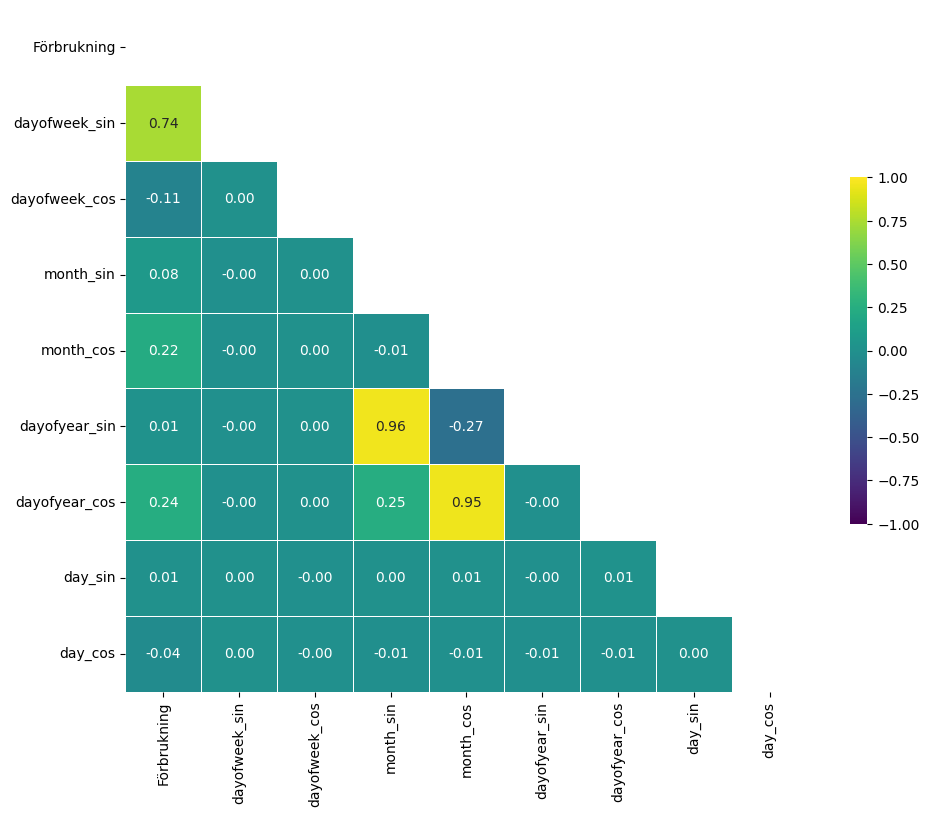

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Calculate correlation coefficients
corr_matrix = Norrbacka_EL[['Förbrukning', 'dayofweek_sin', 'dayofweek_cos','month_sin','month_cos','dayofyear_sin','dayofyear_cos','day_sin','day_cos']].corr()

display(corr_matrix['Förbrukning'])

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("viridis", as_cmap=True)  # Using the viridis colormap for nicer colors

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")  # Adjusting vmin and vmax

plt.show()

# Forecasting Model

## Normalization, Data split, Sequence creation

### Custom functions

In [ ]:
from tensorflow import keras

# Deep learning 
import numpy as np
from tensorflow import keras
from tensorflow.keras import Input
from keras.models import Model
from keras.layers import Dense, LSTM
from keras import losses
from keras.callbacks import EarlyStopping
import h5py

# Custom functions: https://github.com/Eligijus112/Vilnius-weather-LSTM/blob/main/weather-analysis.ipynb

class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=10#5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model

        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

    def save_weights(self, filename):
        self.model.save_weights(filename)

    def save_model(self, filename):
        self.model.save(filename)

def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

2024-04-03 15:28:17.985520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 15:28:18.127443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-03 15:28:18.127472: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-03 15:28:18.154485: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 15:28:18.789340: W tensorflow/stream_executor/platform/de

In [ ]:
# Number of lags (days) to use for models
lag = 7

# Steps ahead to forecast 
n_ahead = 3

# Share of obs in testing 
test_share = 0.2

# Epochs for training
epochs = 50

# Batch size 
batch_size = 16

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 50

In [ ]:
features = ['Förbrukning', 'dayofweek_sin', 'dayofweek_cos']
#features = ['Förbrukning', 'dayofweek_sin', 'month_cos', 'dayofyear_cos']
Norrbacka_EL_clean = Norrbacka_EL[features]

nrows = Norrbacka_EL_clean.shape[0]

# Spliting into train and test sets
train = Norrbacka_EL_clean[0:int(nrows * (1 - test_share))]
test = Norrbacka_EL_clean[int(nrows * (1 - test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
Norrbacka_EL_clean_s = pd.concat([train, test])

X, Y = create_X_Y(Norrbacka_EL_clean_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

In [ ]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (2534, 7, 3)
Shape of the target data: (2534, 3)
Shape of validation data: (634, 7, 3)
Shape of the validation target data: (634, 3)


## Model Creation

### Random search Hyperparameter tuning

In [ ]:
import random

# Step 1: Define the parameter space
param_space = {
    'n_layer': [20, 50, 100],  # Possible number of neurons in the LSTM layer
    'batch_size': [16, 32, 64],  # Possible batch sizes
    'lr': [0.01, 0.001, 0.0001],  # Possible learning rates
    # Add other hyperparameters here as needed
}

# Number of iterations for the random search
n_iter = 10

# Placeholder for storing the performance of each set of parameters
performance_records = []

# Step 2: Random Sampling
for i in range(n_iter):
    # Randomly selecting hyperparameters
    selected_params = {k: random.choice(v) for k, v in param_space.items()}
    print(f"Iteration {i+1}/{n_iter}, trying parameters: {selected_params}")

    # Step 3: Model Training and Evaluation
    model = NNMultistepModel(
        X=Xtrain,
        Y=Ytrain,
        n_outputs=n_ahead,
        n_lag=lag,
        n_ft=n_ft,
        n_layer=selected_params['n_layer'],
        batch=selected_params['batch_size'],
        epochs=epochs,  # You might want to adjust the epochs based on early stopping
        lr=selected_params['lr'],
        Xval=Xval,
        Yval=Yval,
    )
    
    history = model.train()
    val_loss = min(history.history.get('val_loss'))
    
    # Storing the performance along with the corresponding hyperparameters
    performance_records.append((selected_params, val_loss))

# Step 4: Selection of Best Parameters
best_params, best_loss = min(performance_records, key=lambda x: x[1])
print(f"Best parameters: {best_params} with validation loss: {best_loss}")


Iteration 1/10, trying parameters: {'n_layer': 20, 'batch_size': 32, 'lr': 0.01}
2024-04-03 15:28:19.635159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-03 15:28:19.635198: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-03 15:28:19.635222: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-66f0178f-9462-4352-9935-ea41f22cac4b): /proc/driver/nvidia/version does not exist
2024-04-03 15:28:19.635437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epo

In [ ]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=best_params['n_layer'],
    batch=best_params['batch_size'],
    epochs=100,#epochs, 
    lr=best_params['lr'],
    Xval=Xval,
    Yval=Yval,
)

In [ ]:
model.model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 3)]            0         
                                                                 
 lstm_10 (LSTM)              (None, 20)                1920      
                                                                 
 dense_10 (Dense)            (None, 3)                 63        
                                                                 
Total params: 1,983
Trainable params: 1,983
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.train()

Epoch 1/100
80/80 [==============================] - 2s 9ms/step - loss: 0.6287 - val_loss: 0.7123
Epoch 2/100
80/80 [==============================] - 0s 6ms/step - loss: 0.4478 - val_loss: 0.5385
Epoch 3/100
80/80 [==============================] - 0s 6ms/step - loss: 0.3649 - val_loss: 0.4505
Epoch 4/100
80/80 [==============================] - 0s 6ms/step - loss: 0.3316 - val_loss: 0.2879
Epoch 5/100
80/80 [==============================] - 0s 6ms/step - loss: 0.3037 - val_loss: 0.2550
Epoch 6/100
80/80 [==============================] - 0s 5ms/step - loss: 0.2937 - val_loss: 0.2482
Epoch 7/100
80/80 [==============================] - 0s 6ms/step - loss: 0.2888 - val_loss: 0.2473
Epoch 8/100
80/80 [==============================] - 0s 6ms/step - loss: 0.2794 - val_loss: 0.2447
Epoch 9/100
80/80 [==============================] - 0s 5ms/step - loss: 0.2703 - val_loss: 0.2411
Epoch 10/100
80/80 [==============================] - 0s 6ms/step - loss: 0.2755 - val_loss: 0.2534
Epoch 11/

In [ ]:
model.save_weights("norrbacka_el_weights.h5")

In [ ]:
model.save_model('norrbacka_el_model.h5')

/tmp/ipykernel_6380/3789571939.py:7: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.

/tmp/ipykernel_6380/3789571939.py:9: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.



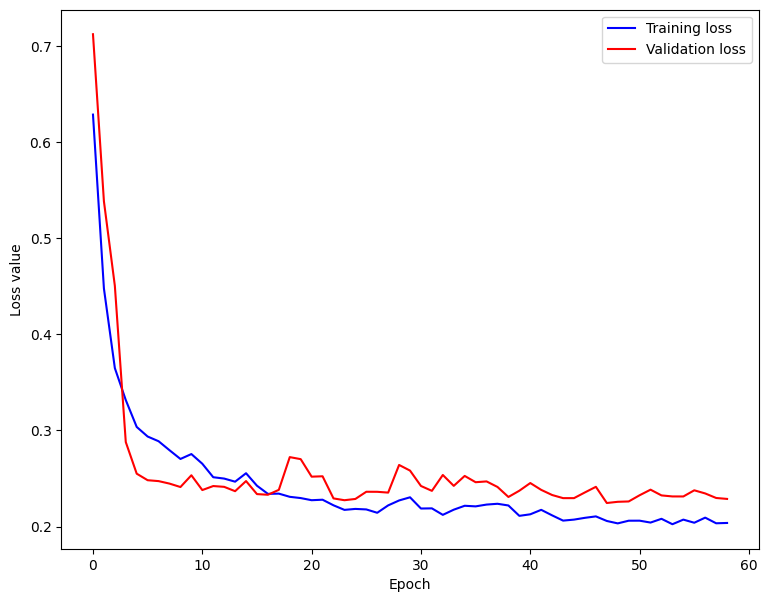

In [ ]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

## Forecasting

In [ ]:
# Forecasting on all the samples in the validation set 
forecast = model.predict(Xval)

20/20 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

target_index = 0

# Reversed Metrics
reversed_forecast = forecast * train_std[target_index] + train_mean[target_index]
reversed_Yval = Yval * train_std[target_index] + train_mean[target_index]

reversed_rmse = mean_squared_error(reversed_Yval, reversed_forecast, squared=False)
reversed_mae = mean_absolute_error(reversed_Yval, reversed_forecast)
reversed_r2 = r2_score(reversed_Yval, reversed_forecast)

print("Reversed RMSE:", reversed_rmse)
print("Reversed MAE:", reversed_mae)
print("Reversed R2 Score:", reversed_r2)

# Scaled Metrics
scaled_rmse = mean_squared_error(Yval, forecast, squared=False)
scaled_mae = mean_absolute_error(Yval, forecast)
scaled_r2 = r2_score(Yval, forecast)

print("Scaled RMSE:", scaled_rmse)
print("Scaled MAE:", scaled_mae)
print("Scaled R2 Score:", scaled_r2)


Reversed RMSE: 75.60344455632077
Reversed MAE: 49.118739340091174
Reversed R2 Score: 0.8836450051790061
Scaled RMSE: 0.352122177157808
Scaled MAE: 0.2287699617679675
Scaled R2 Score: 0.8836450076718858
/tmp/ipykernel_6380/3143089708.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_6380/3143089708.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
import plotly.graph_objects as go

# Reverse scaling on the forecasted and true values
reversed_forecast = forecast * train_std[0] + train_mean[0]
reversed_Yval = Yval * train_std[0] + train_mean[0]

# Create a Plotly figure
fig = go.Figure()

# Add real values
fig.add_trace(go.Scatter(x=Norrbacka_EL_clean_s.index[-len(reversed_Yval):], y=reversed_Yval[:, 0],
                         mode='lines', name='Real Values'))

# Add predicted values
fig.add_trace(go.Scatter(x=Norrbacka_EL_clean_s.index[-len(reversed_forecast):], y=reversed_forecast[:, 0],
                         mode='lines', name='Predicted Values'))

# Update layout
fig.update_layout(title='Real vs Predicted Values for Electricity Consumption Norrbacka',
                  xaxis_title='Date',
                  yaxis_title='Consumption')

# Show plot
fig.show()


/tmp/ipykernel_6380/4083688872.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/tmp/ipykernel_6380/4083688872.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
import plotly.graph_objects as go

# Reverse scaling on the forecasted values
reversed_forecast = forecast * train_std[0] + train_mean[0]

# Create a Plotly figure
fig = go.Figure()

# Add real corrected values
fig.add_trace(go.Scatter(x=Norrbacka_EL_clean.index, y=Norrbacka_EL_clean['Förbrukning'],
                         mode='lines', name='Real Consumption'))

# Add predicted values
fig.add_trace(go.Scatter(x=Norrbacka_EL_clean_s.index[-len(reversed_forecast):], y=reversed_forecast[:, 0],
                         mode='lines', name='Predicted Values'))

# Update layout
fig.update_layout(title='Real Consumption Values and Predicted Values',
                  xaxis_title='Date',
                  yaxis_title='Consumption')

# Show plot
fig.show()


/tmp/ipykernel_6380/2761961515.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cc29b291-e846-4c1e-a1b5-7eaef73de259' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>